In [1]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

import numpy as np

import os

from astropy import units as u
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, match_coordinates_sky

from photutils import background
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from astropy.nddata import Cutout2D
 

In [2]:
path_to_obs = './'
observation_files = ['M67_G.fit', 'M67_B.fit'] 

Green_image = fits.open(path_to_obs + observation_files[0])[0]
Blue_image  = fits.open(path_to_obs + observation_files[1])[0]

bandlist = ['G', 'B']
dict_images = {'G':Green_image, 'B': Blue_image }


In [3]:
dict_aper = {}
for filt in bandlist:
    dict_aper.setdefault(filt, {})
    dict_aper[filt]['sources found'] = None
    dict_aper[filt]['aperture phot table'] = None
    dict_aper[filt]['final aperture phot table'] = None  


In [4]:
def find_bacground(filt='G'):
    #Estimate background level through sigma clipping

    sigma_clip = SigmaClip(sigma=3.) # Everything above 3 sigma will be clipped
    bkg_estimator = background.MedianBackground()

    # Estimate background level by looking at 50x50 cutouts
    bkg = background.Background2D(dict_images[filt].data, (50, 50), filter_size=(3, 3),
                              sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    median = bkg.background_median
    std = bkg.background_rms_median
    return (median, std)

median = {}
stdev  = {}

print("Fiter, Median of background, Noise of background")
for f in bandlist:
    median[f] , stdev[f] = find_bacground(f)

print(median,stdev)


Fiter, Median of background, Noise of background
{'G': 575.9241180419922, 'B': 271.10912704467773} {'G': 7.091783522036177, 'B': 5.64647544558852}


In [5]:
def find_stars(filt='G', var_bkg=False):

    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*stdev[filt])  
    stars = daofind(dict_images[filt].data - median[filt])  

    #stars['filter'] = filt
    for col in stars.colnames:  
        if col not in ('id', 'filter'):
            stars[col].info.format = '%.2f'  # for consistent table output
    return stars
    


for filt in bandlist:
    found_stars = find_stars(filt)
    dict_aper[filt]['sources found'] = found_stars    


dict_aper['G']['sources found'].pprint(max_width=150)   
dict_aper['B']['sources found'].pprint(max_width=150)   


 id  xcentroid ycentroid sharpness roundness1 roundness2  npix sky    peak   flux  mag 
---- --------- --------- --------- ---------- ---------- ----- ---- ------- ----- -----
   1   2226.50      1.85      0.28      -0.80      -0.65 25.00 0.00 1101.49 14.53 -2.91
   2   2244.85      0.62      0.24      -0.46      -0.61 25.00 0.00  125.59  3.35 -1.31
   3   1811.89      3.87      0.60      -0.24      -0.18 25.00 0.00   57.84  1.13 -0.13
   4      0.39     13.47      0.65       0.13       0.85 25.00 0.00   45.53  1.00 -0.00
   5   1141.57     14.90      0.46       0.32       0.20 25.00 0.00  110.07  1.40 -0.36
   6   1452.25     16.61      0.45       0.11       0.25 25.00 0.00 1192.44 13.32 -2.81
   7   1935.99     19.14      0.47       0.02       0.23 25.00 0.00  387.22  3.90 -1.48
   8   2205.73     23.61      0.42       0.03       0.17 25.00 0.00  473.20  4.85 -1.71
   9   1640.81     35.17      0.37       0.14       0.55 25.00 0.00  143.27  1.57 -0.49
  10   2545.29     38.33      0.

In [6]:
def aperture_phot(filt=filt, radius=3.5, sky_in=8, sky_out=15):
    positions = np.transpose((dict_aper[filt]['sources found']['xcentroid'],
                              dict_aper[filt]['sources found']['ycentroid']))
    aperture = CircularAperture(positions, r=radius)
    annulus_aperture = CircularAnnulus(positions, r_in=sky_in, r_out=sky_out)
    annulus_mask = annulus_aperture.to_mask(method='center')

    bkg_median = []
    bkg_stdev = []
    for mask in annulus_mask:
        annulus_data = mask.multiply(dict_images[filt].data)
        annulus_data_1d = annulus_data[mask.data > 0] 
        _, median_sigclip, stdev_sigclip = sigma_clipped_stats(annulus_data_1d)
        bkg_median.append(median_sigclip)
        bkg_stdev.append(stdev_sigclip)

    bkg_median = np.array(bkg_median)
    bkg_stdev = np.array(bkg_stdev)

    error = np.sqrt(dict_images[filt].data)
    phot = aperture_photometry(dict_images[filt].data, aperture, method='exact', error=error)

    phot['annulus_median'] = bkg_median
    phot['aper_bkg'] = bkg_median * aperture.area
    phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

    mask = phot['aper_sum_bkgsub'] > 0

    error_poisson = phot['aperture_sum_err']
    error_scatter_sky = aperture.area * bkg_stdev**2
    error_mean_sky = bkg_stdev**2 * aperture.area**2 / annulus_aperture.area

    fluxerr = np.sqrt(error_poisson + error_scatter_sky + error_mean_sky)
    phot['flux_err'] = fluxerr
    phot = phot [mask]

    phot['mag']    = -2.5 * np.log10(phot['aper_sum_bkgsub']) + 25.0
    phot['mag_err']= 1.086 * (phot['flux_err'] / phot['aper_sum_bkgsub'])

    w = WCS(dict_images[filt].header)
    sky = w.pixel_to_world(phot['xcenter'], phot['ycenter'])
    phot['radec'] = sky
                        
    for col in phot.colnames:  
        if col not in ('id', 'radec'):
            phot[col].info.format = '%.3f'  # for consistent table output
    
    dict_aper[filt]['aperture phot table'] = phot


for filt in bandlist:
    aperture_phot(filt)
    dict_aper[filt]['aperture phot table'].pprint(100, max_width=170)   



Set MJD-AVG to 60725.877836 from DATE-AVG'. [astropy.wcs.wcs]


 id  xcenter  ycenter  aperture_sum aperture_sum_err annulus_median  aper_bkg aper_sum_bkgsub flux_err  mag   mag_err                 radec                
       pix      pix                                                                                                                  deg,deg               
---- -------- -------- ------------ ---------------- -------------- --------- --------------- -------- ------ ------- -------------------------------------
   1 2226.500    1.851    49347.861          222.144        556.130 21402.405       27945.456 1818.171 13.884   0.071  132.7337676379178,12.157918691417347
   3 1811.890    3.865    22675.200          150.583        554.112 21324.724        1350.476 1755.791 17.174   1.412 132.84287963796547,12.147901341989071
   5 1141.569   14.901    24323.470          155.960        561.007 21590.083        2733.388   56.470 16.408   0.022  133.0190678983264,12.129584948655092
   6 1452.254   16.609    48466.255          220.151        567.

 id  xcenter  ycenter  aperture_sum aperture_sum_err annulus_median  aper_bkg aper_sum_bkgsub flux_err  mag   mag_err                  radec                
       pix      pix                                                                                                                   deg,deg               
---- -------- -------- ------------ ---------------- -------------- --------- --------------- -------- ------ -------- -------------------------------------
   1    0.954    1.747     7937.743           89.094          0.000     0.000        7937.743  911.273 15.251    0.125   133.324537279845,12.103072429880054
   2    0.823    6.965     9006.573           94.903          0.000     0.000        9006.573  960.519 15.114    0.116 133.32443942551006,12.101727449574298
   3 1470.337    9.334    24513.006          156.566        266.258 10246.827       14266.180  635.838 14.614    0.048 132.93709902471502,12.135902223900931
   4 1953.879   12.940    15060.697          122.722      

Set MJD-AVG to 60725.820896 from DATE-AVG'. [astropy.wcs.wcs]


In [12]:
max_sep = 1.5 * u.arcsec
filt1 = 'G'
filt2 = 'B'

idx_inst, d2d_inst, _ = match_coordinates_sky(dict_aper[filt1]['aperture phot table']['radec'],
                                              dict_aper[filt2]['aperture phot table']['radec'])

sep_constraint_inst = d2d_inst < max_sep

matched_sources = Table()

matched_sources['id_'+ filt1] = dict_aper[filt1]['aperture phot table']['id'][sep_constraint_inst]
matched_sources['radec'] = dict_aper[filt1]['aperture phot table']['radec'][sep_constraint_inst]
matched_sources['x_' + filt1] = dict_aper[filt1]['aperture phot table']['xcenter'][sep_constraint_inst]
matched_sources['y_' + filt1] = dict_aper[filt1]['aperture phot table']['ycenter'][sep_constraint_inst]

matched_sources['id_'+ filt2] = dict_aper[filt2]['aperture phot table']['id']     [idx_inst[sep_constraint_inst]]
matched_sources['x_' + filt2] = dict_aper[filt2]['aperture phot table']['xcenter'][idx_inst[sep_constraint_inst]]
matched_sources['y_' + filt2] = dict_aper[filt2]['aperture phot table']['ycenter'][idx_inst[sep_constraint_inst]]

matched_sources[filt1 + '_inst'] = dict_aper[filt1]['aperture phot table']['mag'][sep_constraint_inst]
matched_sources['e' + filt1 + '_inst'] = dict_aper[filt1]['aperture phot table']['mag_err'][sep_constraint_inst]

matched_sources[filt2 + '_inst'] = dict_aper[filt2]['aperture phot table']['mag'][idx_inst[sep_constraint_inst]]
matched_sources['e' + filt2 + '_inst'] = dict_aper[filt2]['aperture phot table']['mag_err'][idx_inst[sep_constraint_inst]]

matched_sources.pprint(100, max_width=170)

matched_sources.write('matched_sources.ecsv', overwrite=True)


id_G                 radec                   x_G      y_G    id_B   x_B      y_B    G_inst eG_inst B_inst eB_inst
                    deg,deg                  pix      pix           pix      pix                                 
---- ------------------------------------- -------- -------- ---- -------- -------- ------ ------- ------ -------
  11  133.1303586211521,12.113432113047612  716.432   39.254    7  734.486   30.095 15.957   0.014 16.783   0.021
  13  133.0719535895085,12.118085640070234  938.227   41.233    9  956.132   32.702 15.534   0.009 16.360   0.015
  19 133.09985794693588,12.114361426460226  831.739   46.078   15  849.837   37.223 14.080   0.003 14.817   0.004
  21  133.23906348136236,12.09941441589473  301.637   56.065   22  319.691   46.006 14.664   0.004 15.424   0.007
  24 133.13610298500993,12.106783137672252  692.451   62.915   24  710.413   53.713 12.956   0.001 13.627   0.001
  25 133.01062762430973,12.117865885556558 1169.305   62.924   26 1187.275   54.796 11.1

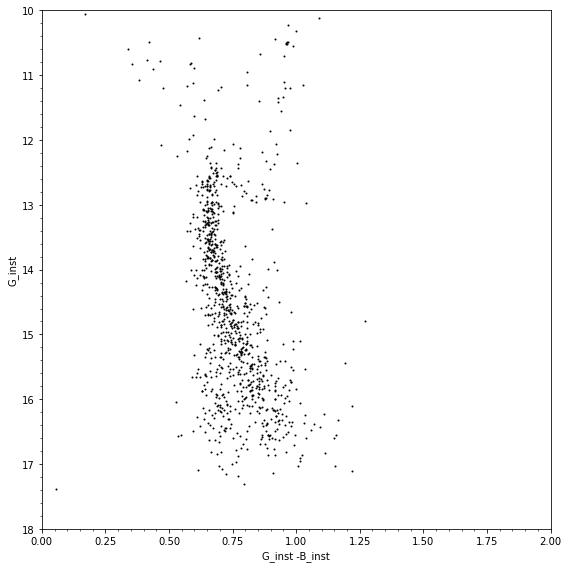

In [13]:
plt.figure(figsize=(8, 8))
plt.clf()

ax1 = plt.subplot()

ax1.set_xlabel(filt1 + '_inst -' + filt2 + '_inst')
ax1.set_ylabel(filt1 + '_inst')

xlim0 = 0
xlim1 = 2.0
ylim0 = 18
ylim1 = 10

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(matched_sources[filt2 + '_inst'] - matched_sources[filt1 + '_inst'], matched_sources[filt1 + '_inst'],
            s=1, color='k')


plt.tight_layout()

In [ ]:
V = g - 0.129 * ( b - g ) - 4.124
B = b + 0.505 * ( b - g ) - 4.804
 